# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 29.01.2022.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям во всех заданиях **запрещено**.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов. 

In [181]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.ANTIALIAS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [182]:
size = 256
images = load_images("data/lfw-a.tgz", (size, size))

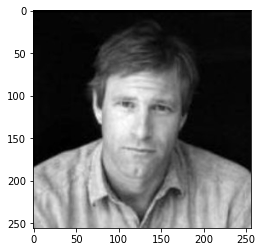

In [183]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [184]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

In [230]:
import itertools
images_tensor = np.array(list(itertools.chain(*images.values())))
M = images_tensor.reshape((images_tensor.shape[0], size * size), order='F').T

(65536, 1053)


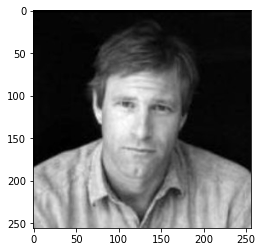

In [232]:
print(M.shape)
plt.imshow(M[:, 0].reshape((size, size), order='F'), cmap='gray');

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.
 
    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [233]:
U, Sigma, V_t = np.linalg.svd(M, full_matrices=False)

Если использовать обычную шкалу, трудно говорить о характере убывания сингулярных чисел

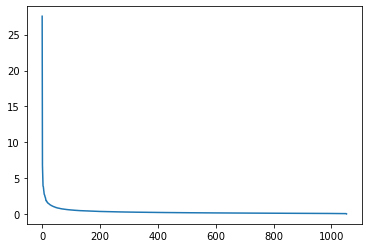

In [234]:
plt.plot(Sigma);

Уже лучше

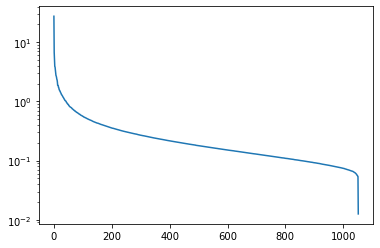

In [235]:
plt.semilogy(Sigma);

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

In [246]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(mat[:,i*cols + j].reshape((size, size), order='F'), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)

Вектор-столбцы матрицы в виде таблицы

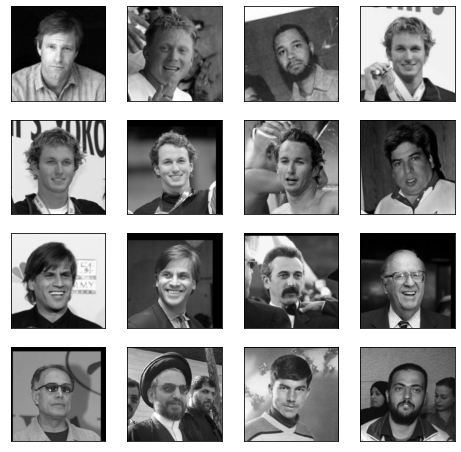

In [247]:
plot_as_images(M, 4, 4)

Несколько первых сингулярных векторов

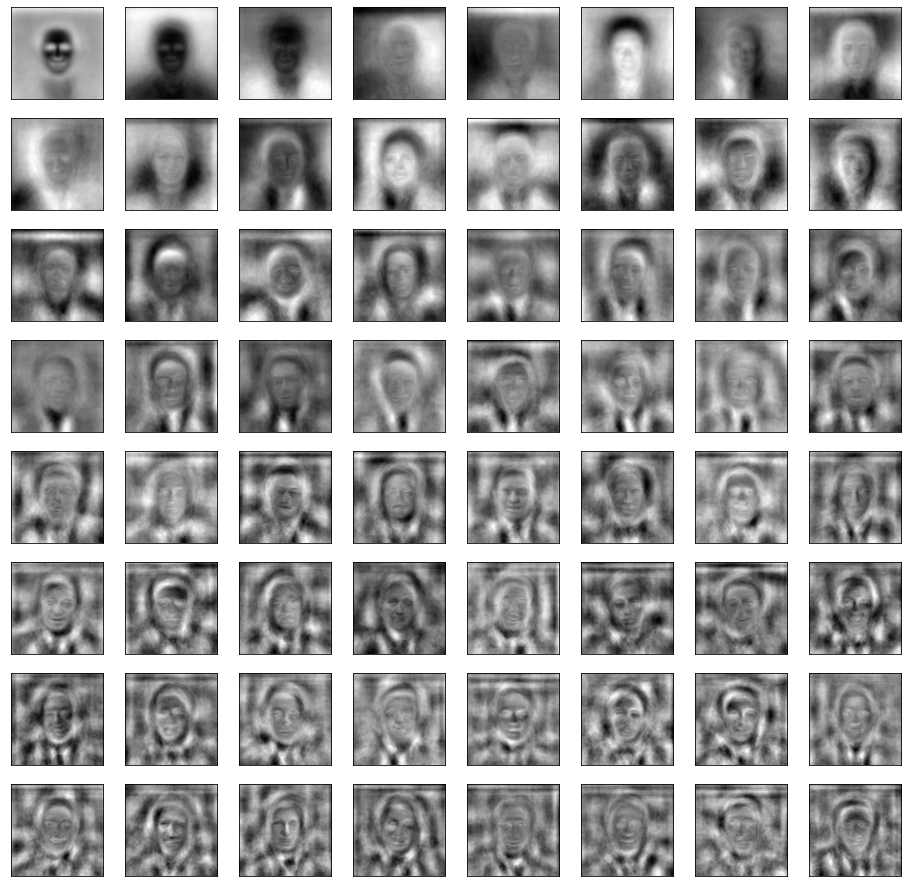

In [248]:
plot_as_images(U, 8, 8)

По-видимому они отвечают за самые контрастные изображения, четко различают силует человека и некоторые части тела. То есть по этим базисным столбцам раскладываются остальные изображения.

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [249]:
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation
            
        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''
    U, Sigma, V_t = np.linalg.svd(M, full_matrices=False)
    return U[:, :r], np.diag(Sigma[:r]) @ V_t[:r, :], np.linalg.norm(Sigma[r:]) / np.linalg.norm(Sigma)

In [240]:
trunc_svd(M, 2)

(array([[-0.00213322,  0.00410322],
        [-0.00217285,  0.00411496],
        [-0.00223139,  0.00425335],
        ...,
        [-0.00292571, -0.00232334],
        [-0.0029236 , -0.00233974],
        [-0.00291816, -0.00233038]]),
 array([[-0.76611841, -0.88613912, -0.91490376, ..., -0.89280903,
         -0.86003099, -0.90218504],
        [-0.4871657 , -0.02804165,  0.1054443 , ...,  0.04715945,
          0.13664409,  0.09819209]]),
 0.48491184830034917)

5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [250]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(M[:, index].reshape((size, size), order='F'), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")
        
        appr = U @ C[:, index]
        axes[1].imshow(appr.reshape((size, size), order='F'), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for i in range(count):
            axes[2 + i].imshow(U[:, i].reshape((size, size), order='F'), cmap="gray") # i-th singular vector image
            axes[2 + i].set_xlabel("{:.7}".format(C[i, index]))
        
        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

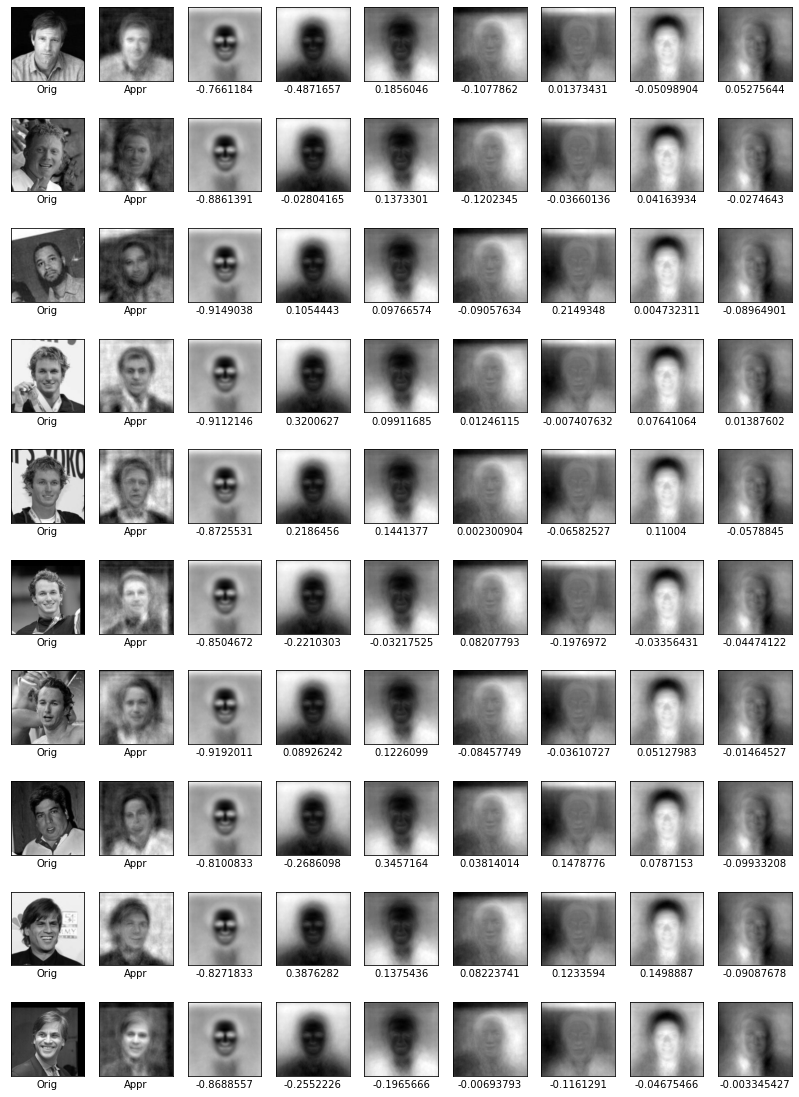

In [251]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [252]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    Omega = np.random.randn(M.shape[1], r + p)
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    W, Sigma, V_t = np.linalg.svd(Q.T @ M, full_matrices=False)
    M_r = (Q @ W)[:, :r] @ np.diag(Sigma[:r]) @ V_t[:r, :]
    return M_r, np.linalg.norm(M - M_r) / np.linalg.norm(M)

In [253]:
rand_svd(M, 10, 10)

(array([[-0.00103911,  0.00308589,  0.00351595, ...,  0.00343928,
          0.0044456 ,  0.00525349],
        [-0.00065629,  0.00304864,  0.00357652, ...,  0.00365882,
          0.00458307,  0.00523487],
        [-0.00043261,  0.00303203,  0.003879  , ...,  0.0039012 ,
          0.00473474,  0.00526269],
        ...,
        [ 0.0028181 ,  0.002439  ,  0.00338063, ...,  0.00378592,
          0.003228  ,  0.00235876],
        [ 0.00292663,  0.0024942 ,  0.0033344 , ...,  0.00386175,
          0.0033019 ,  0.00238482],
        [ 0.00308038,  0.00253979,  0.00319182, ...,  0.00380181,
          0.00325075,  0.00233225]]),
 0.43956611278214297)

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

In [254]:
p_arr = np.arange(0, 105, 5)
Y = np.ndarray(len(p_arr))
r = 50

trunc_err = trunc_svd(M, r)[2]
print(f"trunc_svd")

for i, p in enumerate(p_arr): 
    n_times = 10
    rand_svd_err = np.array([rand_svd(M, r, p)[1] for _ in range(n_times)]).mean()
    print(f"{p} rand_svd")
    Y[i] = rand_svd_err / trunc_err  - 1

plt.semilogy(p_arr, Y);

trunc_svd


KeyboardInterrupt: 

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [ ]:
%timeit trunc_svd(M, 50)

In [ ]:
%timeit rand_svd(M, 50)

In [ ]:
%timeit np.linalg.svd(M, full_matrices=False)

Получается random SVD работает примерно в 5 раз быстрее, чем наивный алгоритм

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [255]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [256]:
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list of count indices of closest images
    """
    M_n = M - new_v.reshape((size * size, 1))
    return np.argsort(np.linalg.norm(M_n, axis=0))[:count]

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

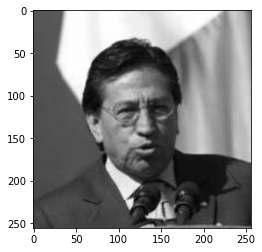

In [257]:
new = test_image
_ = plt.imshow(new, cmap="gray")

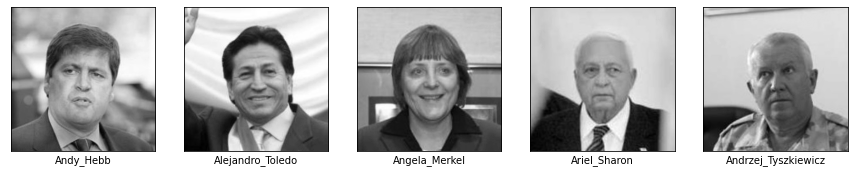

In [258]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [263]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list (of len `count`) of indices of closest images
    """
    U = U[:, 1:] # выкидываем первый столбец
    C = C[1:, :] # коэффициент для умножения на первый столбец тоже не нужен
    pr_v = (U @ (new_v.T @ U)).reshape(size * size, 1)
    Diff = (U @ C) - pr_v
    return np.argsort(np.linalg.norm(Diff, axis=0))[:count]    

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

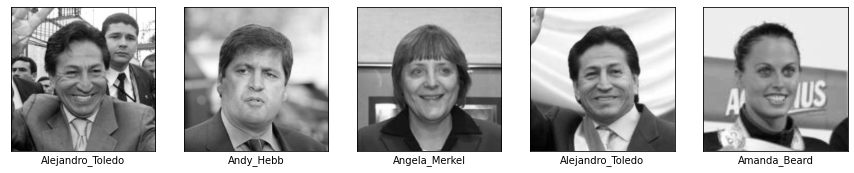

In [264]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.